# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train.shape = ", X_train.shape)
print("X_valid.shape = ",X_valid.shape)
print("X_test.shape = ", X_test.shape)

print("y_train.shape = ", y_train.shape)

X_train.shape =  (34799, 32, 32, 3)
X_valid.shape =  (4410, 32, 32, 3)
X_test.shape =  (12630, 32, 32, 3)
y_train.shape =  (34799,)


## Read the signnames

In [3]:
signnames = pd.read_csv('signnames.csv')
signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_test, y_valid), axis = 0)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

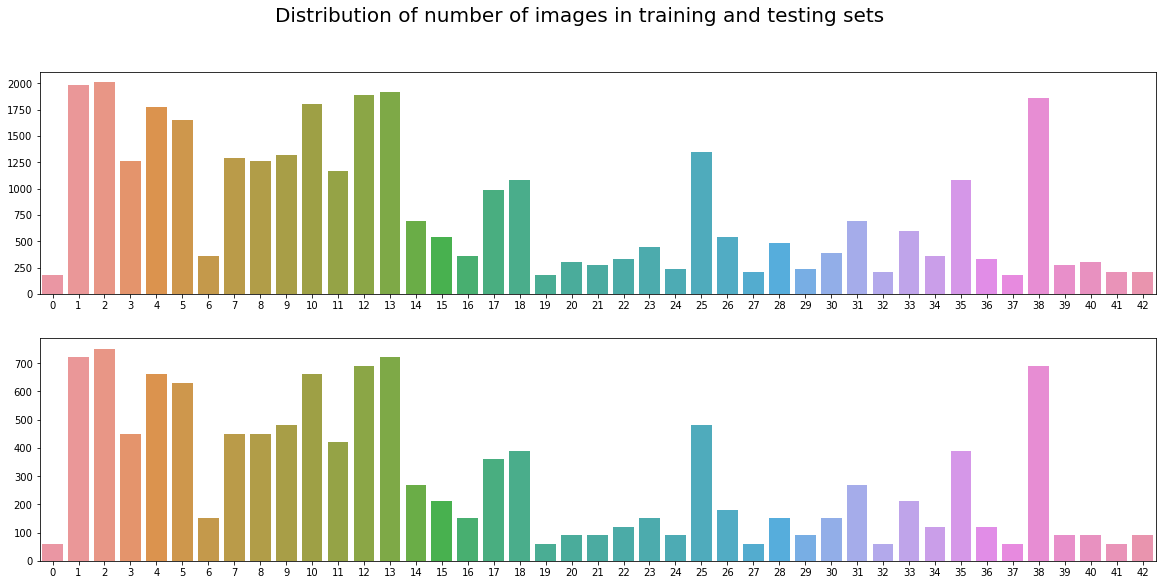

In [5]:
train_signs, train_counts = np.unique(y_train, return_counts = True)
test_signs, test_counts = np.unique(y_test, return_counts = True)
fig, (ax1, ax2) = plt.subplots(2, 1);
fig.set_size_inches(20, 9)
sns.barplot(x = train_signs, y = train_counts, ax = ax1)
sns.barplot(x = test_signs, y = test_counts, ax = ax2);

fig.suptitle("Distribution of number of images in training and testing sets", fontsize = 20);
plt.savefig('images/distribution.png')

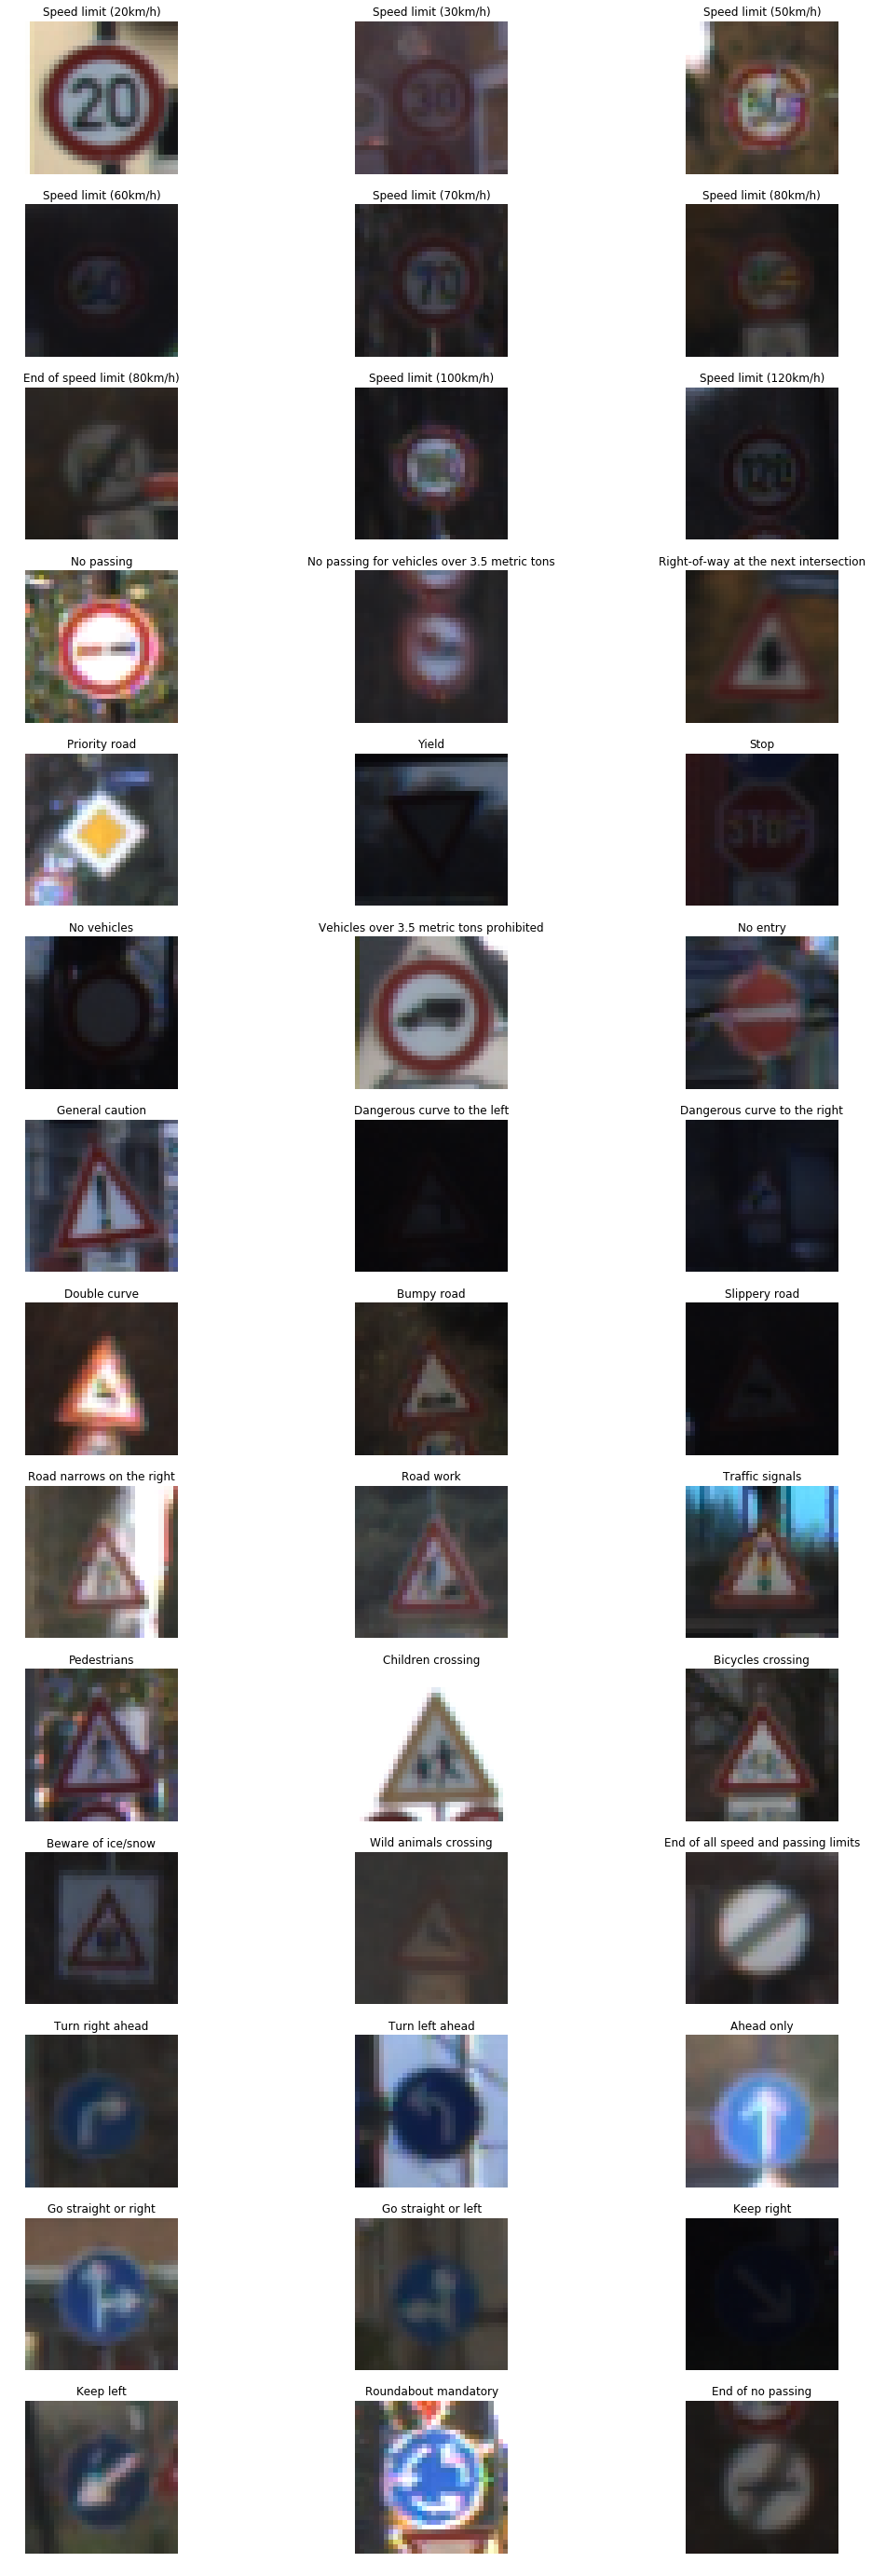

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

fig, ax = plt.subplots(14, 3, figsize=(24, 30))
fig.set_size_inches(18, 50)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax = ax.ravel()
# indices = random.sample(range(len(X_train)), 20)
indices = [(y_train == i).argmax() for i in range(len(ax))]
for i in range(len(ax)):
    image = X_train[indices[i]]
    ax[i].axis('off')
    ax[i].imshow(image)
    name = signnames.iloc[y_train[indices[i]], 1]
    ax[i].set_title(name)
plt.savefig('images/road_signs.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Data Augmentation

### Create New Images by Zooming In and Out of Given Images

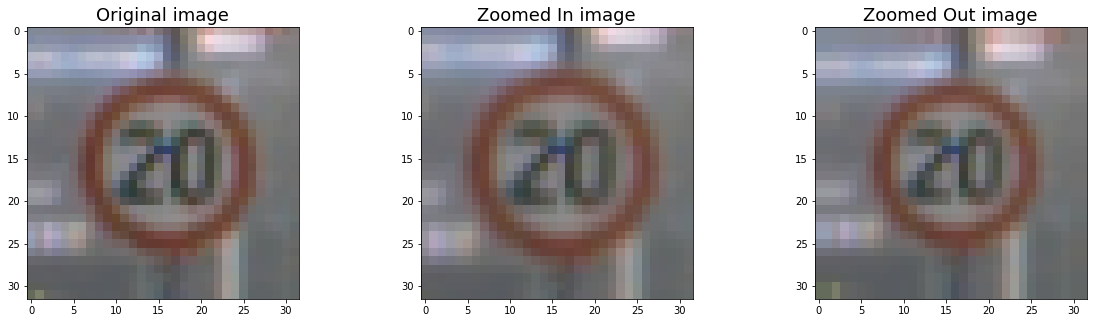

In [7]:
def zoom_in_image(image):
    '''
    input: an image
    
    output: scaled version of the image
    '''
    try:
        in_h, in_w = image.shape[1], image.shape[0]
        x = np.random.normal(0.03, 0.01, 1)
        delta_h = int(np.round(x*in_h))
        y = np.random.normal(0.03, 0.01, 1)
        delta_w = int(np.round(y*in_w))
        out_image = image[delta_h: in_h - delta_h, delta_w: in_w - delta_w]
        out_image = cv2.resize(out_image, dsize = (in_h, in_w))
        return out_image
    except:
        return image

def zoom_out_image(image):
    '''
    input: an image
    
    output: scaled version of the image
    '''
    try:
        in_h, in_w = image.shape[1], image.shape[0]
        x = np.random.normal(0.03, 0.01, 1)
        delta_h = int(np.round(x*in_h))
        y = np.random.normal(0.03, 0.01, 1)
        delta_w = int(np.round(y*in_w))
        out_image = np.copy(image)
        out_image = cv2.resize(out_image, dsize = (in_h*(1-x), in_w*(1-y)))
        top = (in_h - out_image.shape[1])// 2
        bottom = in_h - (out_image.shape[1] + top)
        left =  (in_w - out_image.shape[0])// 2
        right = in_w - (out_image.shape[0] + left)
        out_image = cv2.copyMakeBorder(out_image, left, right, top, bottom, cv2.BORDER_REFLECT)
        return out_image
    except:
        return image

def zoom_in_or_out(image):
    zoom = np.random.choice(['in', 'out'], 1, p = [0.5, 0.5])
    try:
        if zoom == 'in':
            out_image = zoom_in_image(image)
        else:
            out_image = zoom_out_image(image)
    except:
        out_image = image
    return out_image
        

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
ax1.imshow(X_train[10000])
ax1.set_title('Original image', fontsize = 18)
ax2.imshow(zoom_in_image(X_train[10000]))
ax2.set_title('Zoomed In image', fontsize = 18)
ax3.imshow(zoom_out_image(X_train[10000]))
ax3.set_title('Zoomed Out image', fontsize = 18);
plt.savefig('images/zoomed_in_and_out.png')

### Create New Images by Translating or Rotating the Given Images

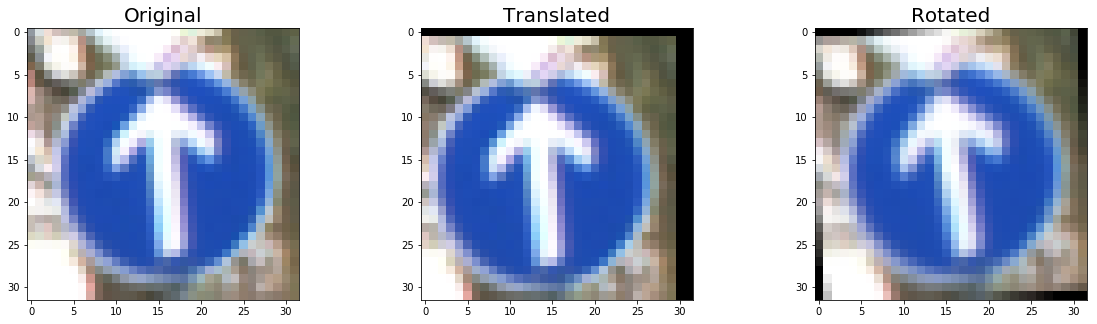

In [8]:
def translate_image(image):
    '''
    input: an image
    
    output: randomly translated image in x and y directions
    '''
    in_h, in_w = image.shape[1], image.shape[0]
    pixels_allowed = 3
    delta_x, delta_y = np.random.randint(-pixels_allowed, pixels_allowed, 2)
    M = np.float32([[1, 0, delta_x], [0, 1, delta_y]])
    out_image = cv2.warpAffine(image, M, (in_w, in_h))
    return out_image

def rotate_image(image):
    '''
    input: an image
    
    output: randomly translated image in x and y directions
    source: https://stackoverflow.com/a/9042907
    '''
    angle_allowed = 30
    angle = np.random.randint(-angle_allowed, angle_allowed, 1)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    out_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return out_image
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
ax1.imshow(X_train[20000])
ax1.set_title('Original', fontsize = 20)
ax2.imshow(translate_image(X_train[20000]))
ax2.set_title('Translated', fontsize = 20)
ax3.imshow(rotate_image(X_train[20000]))
ax3.set_title('Rotated', fontsize = 20)
plt.savefig('images/translated_and_rotated.png');

In [9]:
def augment_training_data(X_data, y_data):
    assert len(X_data) == len(y_data), "X and y data have different lengths"
    X_out, y_out = X_data, y_data
    y_categories, y_counts = np.unique(y_data, return_counts = True)
    max_count = max(y_counts)
    for i in y_categories:
        if y_counts[i] <= 750:
            N = 750 - y_counts[i]
        else:
            N = 50
            
        start_time = time.time()
        cat_indices = np.where(y_data == i)[0]
        for j in range(N):
            random_index = np.random.choice(cat_indices)
            transformation = np.random.choice(['first', 'second', 'third', 'fourth'], 1, p = [0.25, 0.25, 0.25, 0.25])
            if transformation == 'first':
                X_out = np.concatenate((X_out, [zoom_in_image(X_data[random_index])]), axis = 0)
            elif transformation == 'second':
                X_out = np.concatenate((X_out, [zoom_out_image(X_data[random_index])]), axis = 0)
            elif transformation == 'third':
                X_out = np.concatenate((X_out, [translate_image(X_data[random_index])]), axis = 0)
            elif transformation == 'fourth':
                X_out = np.concatenate((X_out, [rotate_image(X_data[random_index])]), axis = 0)

            y_out = np.concatenate((y_out, [i]))
        end_time = time.time()
        print('time taken for image number %d = ' %i, (end_time - start_time)//60, ' minutes and ', round((end_time - start_time)%60, 2), ' seconds')
    return X_out, y_out

# X_train_augmented, y_train_augmented = augment_training_data(X_train, y_train)

## Save original and augmented training data to disk

In [10]:
# augmented_training_data = 'augmented_training_data.pkl'
# with open('augmented_training_data.pkl', 'wb') as file:
#         pickle.dump(
#             {
#                 'X_train_augmented': X_train_augmented,
#                 'y_train_augmented': y_train_augmented,
#             },
#             file, pickle.HIGHEST_PROTOCOL)

In [11]:
pickle_file = 'augmented_training_data.pkl'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train_augmented = pickle_data['X_train_augmented']
    y_train_augmented = pickle_data['y_train_augmented']
    #del pickle_data  # Free up memory

print('Augmented data loaded.')

Augmented data loaded.


(46030,) (34799,)
(46030, 32, 32, 3) (34799, 32, 32, 3)


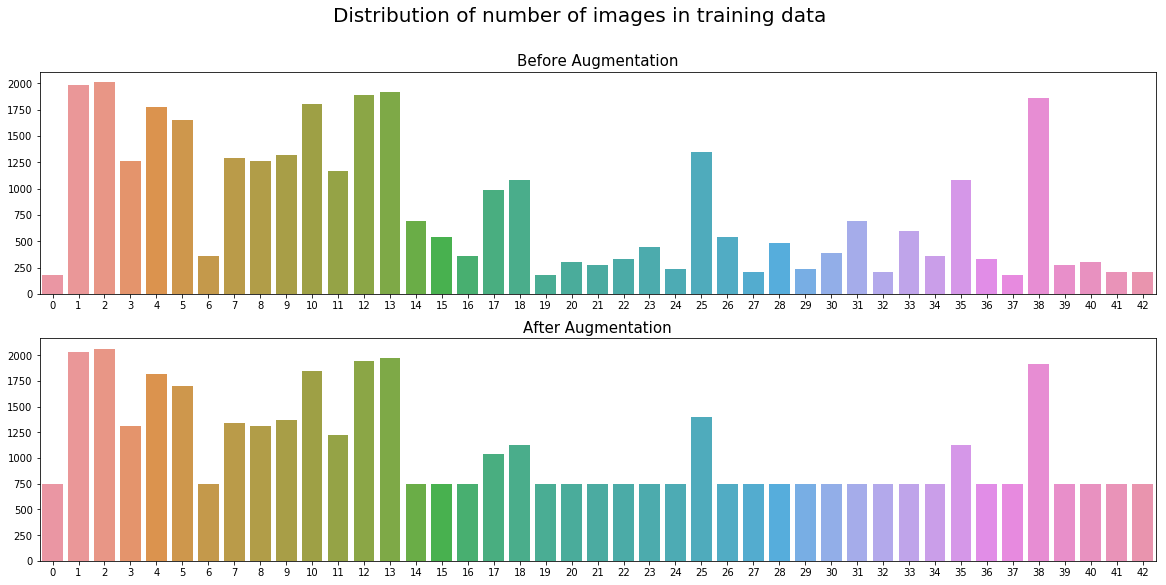

In [12]:
print(y_train_augmented.shape, y_train.shape)
print(X_train_augmented.shape, X_train.shape)

train_aug_signs, train_aug_counts = np.unique(y_train_augmented, return_counts = True)

# test_signs, test_counts = np.unique(y_test, return_counts = True)
fig, (ax1, ax2) = plt.subplots(2, 1);
fig.set_size_inches(20, 9)
sns.barplot(x = train_signs, y = train_counts, ax = ax1)
ax1.set_title('Before Augmentation', fontsize = 15)
sns.barplot(x = train_aug_signs, y = train_aug_counts, ax = ax2)
ax2.set_title('After Augmentation', fontsize = 15);

fig.suptitle("Distribution of number of images in training data", fontsize = 20);
plt.savefig('images/distribution_after_augment.png')

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
# Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def pre_process_features(input_df):
    '''
    preprocess input data
    '''
    # convert to grayscale
    out_df = np.mean(input_df, axis=3, keepdims=True)
    # normalize between -1 and 1
    out_df = (out_df - 128)/128
    return out_df
# X_train_preprocessed = pre_process_features(X_train)
# plt.hist(X_train[:, :, ].flatten());


16


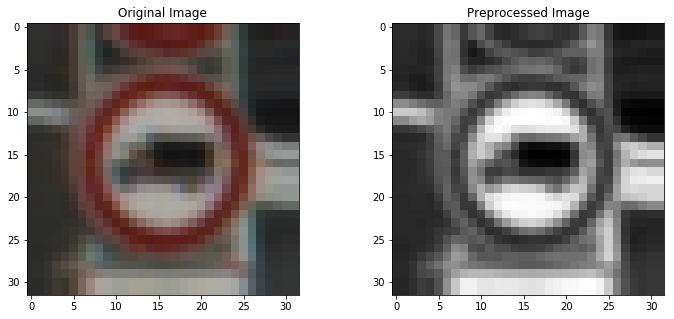

In [14]:
# Preprocess all the datasets here
X_train_preprocessed = pre_process_features(X_train_augmented)
X_valid_preprocessed = pre_process_features(X_valid)
X_test_preprocessed = pre_process_features(X_test)
print(y_train_augmented[37000])
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
ax1.imshow(X_train_augmented[37000]);
ax1.set_title('Original Image')
ax2.imshow((X_train_preprocessed[37000]).squeeze(), cmap = 'gray');
ax2.set_title('Preprocessed Image')
plt.savefig('images/preprocessed.png')

### Check if the density distributions of the grayscale and the normalized grayscale are the same

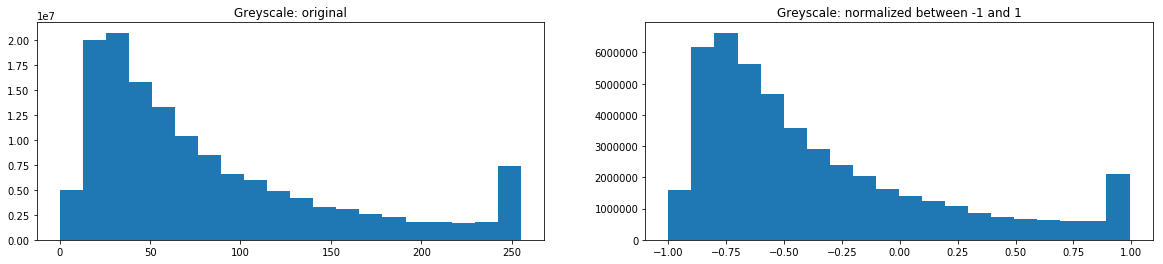

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 4)
ax1.hist(X_train_augmented[:,:, ].flatten(), bins = 20)
ax1.set_title('Greyscale: original');
ax2.hist(X_train_preprocessed[:,: , ].flatten(), bins = 20);
ax2.set_title('Greyscale: normalized between -1 and 1');
plt.savefig('images/preprocess_distribution.png')

### Model Architecture

In [16]:
# Define your architecture here.
# Feel free to use as many code cells as needed.


# source: https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb
## I modified the LeNet acchitecture to suit the needs of the problem at hand
def LeNet_modified(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input(x) = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
#     fc0 = tf.nn.dropout(fc0, keep_prob=0.3)    
    # SOLUTION: Layer 3: Fully Connected. Input = 800. Output = 160.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 160), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(160))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, keep_prob=0.5)

    # SOLUTION: Layer 4: Fully Connected. Input = 160. Output = 60.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(160, 80), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(80))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 60. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(80, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
#### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
# keep_prob = tf.placeholder(tf.float32) # probability to keep units

rate = 0.001

logits = LeNet_modified(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
EPOCHS = 40
BATCH_SIZE = 64
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_preprocessed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        epoch_start_time = time.time()
        print("EPOCH {} running ...".format(i+1))
        X_train_preprocessed, y_train_augmented = shuffle(X_train_preprocessed, y_train_augmented)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_preprocessed[offset:end], y_train_augmented[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        training_accurary = evaluate(X_train_preprocessed, y_train_augmented)
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        train_accuracy.append(training_accurary)
        valid_accuracy.append(validation_accuracy)
        epoch_end_time = time.time()
        
        print("total time taken = ", (epoch_end_time - epoch_start_time)//60, ' minutes and', round((epoch_end_time - epoch_start_time)%60), ' seconds')
        print("Training Accuracy = {:.3f}".format(training_accurary))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()    
    saver.save(sess, 'models/LeNet_modified')
    print("Model saved")
end_time = time.time()
print("total time taken = ", (end_time - start_time)//60, ' minutes and', round((end_time - start_time)%60), ' seconds')

Training...

EPOCH 1 running ...
total time taken =  1.0  minutes and 55  seconds
Training Accuracy = 0.812
Validation Accuracy = 0.777

EPOCH 2 running ...
total time taken =  1.0  minutes and 57  seconds
Training Accuracy = 0.911
Validation Accuracy = 0.873

EPOCH 3 running ...
total time taken =  1.0  minutes and 58  seconds
Training Accuracy = 0.941
Validation Accuracy = 0.899

EPOCH 4 running ...
total time taken =  1.0  minutes and 59  seconds
Training Accuracy = 0.949
Validation Accuracy = 0.902

EPOCH 5 running ...
total time taken =  1.0  minutes and 58  seconds
Training Accuracy = 0.957
Validation Accuracy = 0.907

EPOCH 6 running ...
total time taken =  1.0  minutes and 57  seconds
Training Accuracy = 0.965
Validation Accuracy = 0.916

EPOCH 7 running ...
total time taken =  1.0  minutes and 57  seconds
Training Accuracy = 0.969
Validation Accuracy = 0.929

EPOCH 8 running ...
total time taken =  1.0  minutes and 55  seconds
Training Accuracy = 0.969
Validation Accuracy = 0.

In [20]:
print(train_accuracy)
print(valid_accuracy)

[0.81199217900850706, 0.91129698022251515, 0.94101672821295612, 0.94922876384966326, 0.95689767542906801, 0.96491418640017379, 0.96867260482553141, 0.96923745383445581, 0.97514664349337388, 0.97844883771453395, 0.97710189007169235, 0.97979578535737566, 0.98355420378014335, 0.98385835324788184, 0.9814903323919183, 0.98650879860960239, 0.98248968064305886, 0.9835107538561807, 0.98709537258309799, 0.98646534868563984, 0.98262003041494672, 0.98746469693678041, 0.98789919616863719, 0.98737779708885509, 0.98770367151857485, 0.98674777319139695, 0.98742124701281775, 0.98915924397132304, 0.98961546817293067, 0.99065826634026444, 0.99007169237453829, 0.98802954595088444, 0.99198348902889422, 0.99000651748859436, 0.99194003910493156, 0.99152726482728659, 0.99230936345861398, 0.99131001520747342, 0.99072344123397782, 0.99148381489555448]
[0.77664399125408423, 0.87346938805244945, 0.89886621320599058, 0.90204081611027798, 0.90657596347553659, 0.91609977299934608, 0.92925170070730367, 0.93083900253

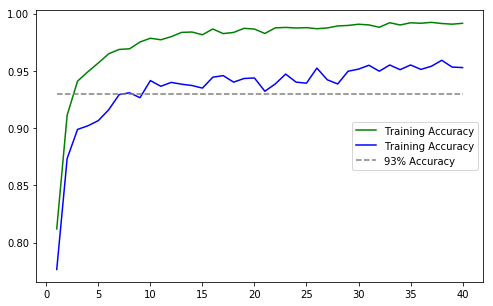

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plt.plot(np.arange(1, EPOCHS+1), train_accuracy, color = 'g', label = 'Training Accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accuracy, color = 'b', label = 'Training Accuracy')
plt.plot(np.arange(1, EPOCHS+1), [.93]*EPOCHS, color = 'gray', linestyle = '--', label = '93% Accuracy')
plt.legend(loc='right', fontsize = 'medium')
plt.savefig('images/accuracy.png')
plt.show();

## Load the Model and Evaluate on Test Images

In [22]:
print('Testing against test set.\n')

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'models/lenet')
    print("\nRunning Test set...")
    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}%".format(test_accuracy*100))
#     print('Compared to human: {:.2f}% less\n'.format((human_acc - test_accuracy)*100))

Testing against test set.

INFO:tensorflow:Restoring parameters from models/lenet

Running Test set...
Test Accuracy = 93.310%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
downloaded_images = os.listdir('downloaded_street_signs/')
downloaded_images.pop(downloaded_images.index('.ipynb_checkpoints'))
    
print(downloaded_images)

['31_wild_animals_crossing.jpeg', '8_speed_limit_120kmh.jpg', '24_road_narrows_on_the_right.jpg', '2_Speed_limit_50km_h.jpg', '28_Children_crossing.jpg', '22_bumpy_road.jpg', '14_stop.jpeg', '30_Beware of ice_snow.jpg']


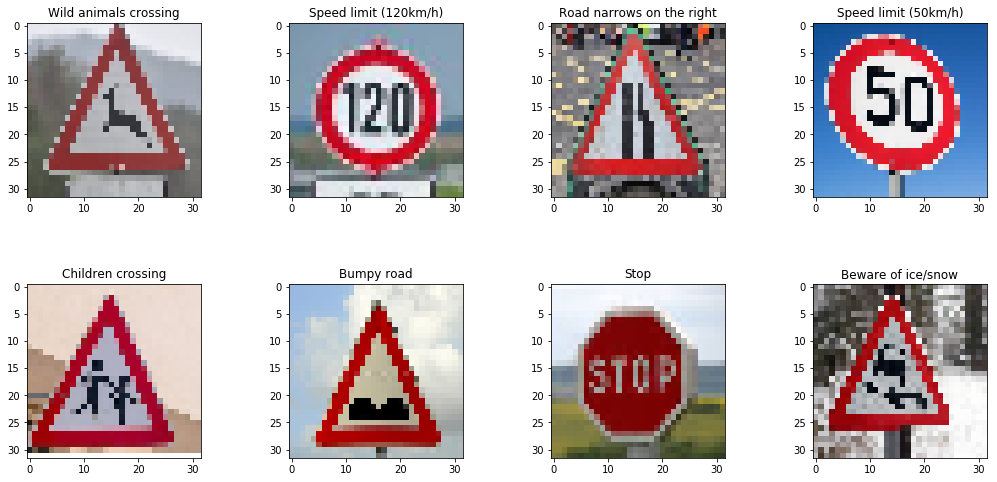

In [24]:
X_downloaded_images = []
y_downloaded_images = np.array([31, 8, 24, 2, 28, 22, 14, 30])
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(18, 8)
ax = ax.ravel()

for i in range(len(downloaded_images)):
    test_image = plt.imread(os.path.join('downloaded_street_signs', downloaded_images[i]))
    test_image = cv2.resize(test_image, (32, 32))
    X_downloaded_images.append(test_image)
    ax[i].imshow(test_image)
    name = signnames.iloc[y_downloaded_images[i], 1]
    ax[i].set_title(name)
plt.subplots_adjust(hspace=0.5)
plt.savefig('images/downloaded_images.png')

### Pre-process the downloaded test images

In [25]:
X_downloaded_images = np.array(X_downloaded_images)
X_downloaded_preprocessed = pre_process_features(X_downloaded_images)

### Predict the Sign Type for Each Image

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
### Feel free to use as many code cells as needed.
pred_prob = tf.nn.softmax(logits)
top5 = tf.nn.top_k(pred_prob, 5)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'models/lenet')
    pred = sess.run(top5, feed_dict = {x: X_downloaded_preprocessed, y: y_downloaded_images})


INFO:tensorflow:Restoring parameters from models/lenet


In [29]:
for i in range(len(y_downloaded_images)):
    actual = signnames.iloc[y_downloaded_images[i], 1]
    predicted = signnames.iloc[pred[1][i][0], 1]
    if actual == predicted:
        result = 'Right classification'
    else:
        result = 'Wrong classification'
    print(result, "::: actual image = ", actual, ';  predicted image =', predicted, '\n')

Wrong classification ::: actual image =  Wild animals crossing ;  predicted image = Double curve 

Right classification ::: actual image =  Speed limit (120km/h) ;  predicted image = Speed limit (120km/h) 

Right classification ::: actual image =  Road narrows on the right ;  predicted image = Road narrows on the right 

Wrong classification ::: actual image =  Speed limit (50km/h) ;  predicted image = Speed limit (20km/h) 

Wrong classification ::: actual image =  Children crossing ;  predicted image = Bicycles crossing 

Right classification ::: actual image =  Bumpy road ;  predicted image = Bumpy road 

Right classification ::: actual image =  Stop ;  predicted image = Stop 

Wrong classification ::: actual image =  Beware of ice/snow ;  predicted image = Speed limit (120km/h) 



### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("Test Accuracy on New Downloaded Images = {:.1f}%".format(100*np.average([a[0] for a in pred[1]] == y_downloaded_images), "%"))

Test Accuracy on New Downloaded Images = 50.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print(pred)

TopKV2(values=array([[  9.99984384e-01,   1.55726502e-05,   5.95652727e-09,
          1.61918423e-10,   4.03556615e-12],
       [  1.00000000e+00,   2.16018904e-21,   2.45549769e-25,
          5.08993944e-30,   5.17812503e-31],
       [  9.99999881e-01,   1.25089102e-07,   3.15701443e-09,
          1.32184680e-11,   4.47279238e-14],
       [  9.56233919e-01,   4.37618569e-02,   4.16868670e-06,
          3.40802277e-16,   3.03292588e-17],
       [  7.49277174e-01,   2.50580370e-01,   1.41666693e-04,
          4.77847209e-07,   3.25150779e-07],
       [  1.00000000e+00,   1.94829431e-37,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.99998569e-01,   1.30303169e-06,   1.00295388e-07,
          1.76619395e-08,   6.93440017e-09],
       [  9.69049275e-01,   2.77113877e-02,   1.84150937e-03,
          1.32849161e-03,   5.75581180e-05]], dtype=float32), indices=array([[21, 31, 23, 40, 27],
       [ 8,  7,  5,  9, 16],
       [24, 26, 21, 29, 40],
       [ 0,  1,  2

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")